# Identify procedural reasons for 'all-nothing-all' mutations (Part 1)
## April 4, 2017

Mutations that have 100% frequency in one generation, disappear completely (0%) in the next generation sampled, then reappear at 100% frequency. Potential explanations: 

1. Biological - Frequency-dependent selection? 
2. Procedural - Undersampled populations? Missing coverage during sequencing? Breseq frequency threshold for polymorphism mode (5-95%) not met?

Input: 
1. HTML file from gdtools COMPARE
2. GD files (annotated.gd) from breseq output.

Tasks:
1. Identify rows with 'all-nothing-all' (a-n-a) pattern in input HTML file, by mutation position.
2. For each a-n-a, identify mutation position and generation(s) when 0% frequency occurs.
3. For each 0% frequency occurrence in a-n-a, refer to relevant annotated.gd file to identify reason for frequency.
4. Use prototype scripts here to build methods. See [lost_polymorphisms.py](https://github.com/yeemey/dvh_mms2/blob/master/lost_polymorphisms.py).

#### Note:

The following Part 1 prototype scripts have since been improved upon in [lost_polymorphisms.py](https://github.com/yeemey/dvh_mms2/blob/master/lost_polymorphisms.py) and no longer reflect what was used in analyses.

```
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd

ua3 = BeautifulSoup(open('/Users/ymseah/Documents/compare/UA3.html'), 'html.parser')

#Task 1-2

#1. Identify line-generation headers
line_generations = []
next_line_gen = ua3.find('th', string=re.compile('0'))
line_gen = next_line_gen.string
while line_gen != 'annotation':
    line_generations.append(line_gen)
    next_line_gen = next_line_gen.next_element.next_element.next_element
    line_gen = next_line_gen.string
print(line_generations)

#2. Identify ref genome and polymorphism position
#3. Identify frequencies across generations
#4. Link 2. and 3.

table_cells = ua3.body.find_all('td')
generation_frequencies_dict = {}
for cell in table_cells:
    if re.match('NC_', str(cell.string)):
        position = cell.next_sibling.next_sibling.next_sibling
        clean_position = int(re.sub(',', '', position.string))
        gen_freqs_key = (cell.string, clean_position)
        mutation = position.next_sibling.next_sibling.next_sibling
        freq_ancestor = mutation.next_sibling.next_sibling.next_sibling
        freq_gen100 = freq_ancestor.next_sibling
        freq_gen300 = freq_gen100.next_sibling
        freq_gen500 = freq_gen300.next_sibling
        freq_gen780 = freq_gen500.next_sibling
        freq_gen1000 = freq_gen780.next_sibling
        gen_freqs_value = [mutation.string, freq_ancestor.string, freq_gen100.string, freq_gen300.string, freq_gen500.string, freq_gen780.string, freq_gen1000.string]
        generation_frequencies_dict[gen_freqs_key] = gen_freqs_value

#5. Identify a-n-a pattern.

suspect_frequencies_dict = {}
with open('suspect_frequencies.tsv', 'w') as output_file:
    output_file.write('ref_genome\tposition\tmutation\tfreq_anc\tfreq_100\tfreq_300\tfreq_500\tfreq_780\tfreq_1000\n')
    for key, value in generation_frequencies_dict.items():
        counter = 2
        while counter <= len(value):
            if counter + 1 < len(value):
                if value[counter] == None:
                    if value[counter - 1] == '100%' or value[counter + 1] == '100%':
                        suspect_frequencies_dict[key] = value
                        output_file.write(key[0] + '\t' + str(key[1]) + '\t')
                        for item in value:
                            output_file.write(str(item) + '\t')
                        output_file.write('\n')
                elif value[counter] == '100%':
                    if value[counter - 1] == None or value[counter + 1] == None:
                        suspect_frequencies_dict[key] = value
                        output_file.write(key[0] + '\t' + str(key[1]) + '\t')
                        for item in value:
                            output_file.write(str(item) + '\t')
                        output_file.write('\n')
            counter += 2

UA3_100 = pd.read_table('/Users/ymseah/Documents/sic_UA3-15_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_100.insert(0, 'generation', 100)
UA3_300 = pd.read_table('/Users/ymseah/Documents/sic_UA3.45_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_300.insert(0, 'generation', 300)
UA3_500 = pd.read_table('/Users/ymseah/Documents/sic_UA3-76_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_500.insert(0, 'generation', 500)
UA3_780 = pd.read_table('/Users/ymseah/Documents/sic_UA3.118_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_780.insert(0, 'generation', 780)
UA3_1000 = pd.read_table('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/evidence/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_1000.insert(0, 'generation', 1000)

UA3_df  = pd.concat([UA3_100, UA3_300, UA3_500, UA3_780, UA3_1000], ignore_index=True)
UA3_df.insert(0, 'line', 'UA3')
UA3_df.insert(2, 'frequency', 0.0)
UA3_df.insert(3, 'gene_product', '')
UA3_df.insert(4, 'gene_position', '')
UA3_df.insert(5, 'reject', '')

for row in UA3_df.itertuples():
    #check each column
    col_index = 6
    while col_index < 50:
        #1. polymorphism frequencies
        if re.match('frequency=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_df.loc[row[0], col_index]))
        #2. gene products
        elif re.match('gene_product=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'gene_product'] = re.sub('gene_product=', '', str(UA3_df.loc[row[0], col_index]))
        #3. polymorphism rejection reasons
        elif re.match('reject=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'reject'] = re.sub('reject=', '', str(UA3_df.loc[row[0], col_index]))
        #4. gene annotations
        elif re.match('gene_position=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'gene_position'] = re.sub('gene_position=', '', str(UA3_df.loc[row[0], col_index]))
        col_index += 1
    #set frequencies type to float
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_df.loc[row[0], 'frequency'])):
        UA3_df.loc[row[0], 'frequency'] = float(UA3_df.loc[row[0], 'frequency'])
    else:
        UA3_df.loc[row[0], 'frequency'] = 0.0
    #set positions (col 4) type to int
    UA3_df.loc[row[0], 4] = int(UA3_df.loc[row[0], 4])
    #set reject col to 'NA' when no reject reason given.
    if (UA3_df.loc[row[0], 'reject'] == '') & (UA3_df.loc[row[0], 2] == '.'):
        UA3_df.loc[row[0], 'reject'] = 'NA'

UA3_df.rename(columns = {0: 'entry_type', 1: 'item_id', 2: 'evidence_ids', 3: 'ref_genome', 4:'position'}, inplace=True)
ua3df_subset = UA3_df[['line', 'generation', 'frequency', 'gene_product', 'gene_position', 'reject', 'entry_type', 'item_id', 'evidence_ids', 'ref_genome', 'position']].copy()
ua3df_subset.to_csv('/Users/ymseah/Documents/ua3.csv', index=False)

# Task 3.
#6: Identify reasons for a-n-a frequencies.

ua3df_subset_mutations_only = ua3df_subset[(ua3df_subset['entry_type'] == 'SNP') | 
                                           (ua3df_subset['entry_type'] == 'SUB') | 
                                           (ua3df_subset['entry_type'] == 'DEL') | 
                                           (ua3df_subset['entry_type'] == 'INS') | 
                                           (ua3df_subset['entry_type'] == 'MOB') | 
                                           (ua3df_subset['entry_type'] == 'AMP') | 
                                           (ua3df_subset['entry_type'] == 'CON') | 
                                           (ua3df_subset['entry_type'] == 'INV')]
for key, value in suspect_frequencies_dict.items():
    row_indices = ua3df_subset_mutations_only[(ua3df_subset_mutations_only['ref_genome'] == key[0]) & 
                                              (ua3df_subset_mutations_only['position'] == key[1])].index.tolist()
    #print(key, row_indices)
    for row in row_indices:
        reject_reason = ua3df_subset_mutations_only.loc[row, 'reject']
        generation = ua3df_subset_mutations_only.loc[row, 'generation']
        entry_type = ua3df_subset_mutations_only.loc[row, 'entry_type']
        #print(row, reject_reason, generation, entry_type)
        if reject_reason != '':
            if generation == 100:
                value[2] = str(value[2]) + ' ' + reject_reason
            elif generation == 300:
                value[3] = str(value[3]) + ' ' + reject_reason
            elif generation == 500:
                value[4] = str(value[4]) + ' ' + reject_reason
            elif generation == 780:
                value[5] = str(value[5]) + ' ' + reject_reason
            elif generation == 1000:
                value[6] = str(value[6]) + ' ' + reject_reason
```

## Part 1 Problems & Solutions

#### String sorting messes up generation order. 

```
find_line_generations = set(ua3.find_all('th', string=re.compile('UA3')))
line_generations=['0']
for each in find_line_generations:
    line_generations.append(each.string)
    line_generations.sort()
print(line_generations)
```

- Solved by appending in order of appearance in document.


#### Identifying frequencies in each row, when there are no string elements within each cell to represent 0% frequency. 


```
frequencies_by_generations = {}
all_comments = ua3.find_all(text = lambda text:isinstance(text, Comment))
for comment in all_comments:
    if comment == ' Seq_Id ':
        ref_genome = comment.previous_element.strip()
        position = comment.next_element.next_element.next_element.strip()
        genome_position_key = (ref_genome, position)
        generation_frequencies_value = []
        #gen_freq = comment.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.next_element.strip()
        print(genome_position_key)
```

- Solved by listing each cell (td) as an element and searching within td. Initially, searching was by html comment position, but it got messy.


# Identify procedural reasons for 'all-nothing-all' mutations (Part 2)
## April 24, 2017

Tasks:
1. Use output from [lost_polymorphisms_runScript.py](https://github.com/yeemey/dvh_mms2/blob/master/lost_polymorphisms_runScript.py) to classify procedural reasons, summary counts.

In [16]:
import numpy as np
import pandas as pd

ua3_freqs = pd.read_csv('~/Documents/compare/parse_compare/UA3_suspect_frequencies.tsv', sep='\t')
ua3_evidence = pd.read_csv('~/Documents/compare/parse_compare/UA3_rejected_evidence.tsv', sep='\t')
ua3freqs_evidence = pd.merge(ua3_freqs, ua3_evidence, how='left', on='position')

ue3_freqs = pd.read_csv('~/Documents/compare/parse_compare/UE3_suspect_frequencies.tsv', sep='\t')
ue3_evidence = pd.read_csv('~/Documents/compare/parse_compare/UE3_rejected_evidence.tsv', sep='\t')
ue3freqs_evidence = pd.merge(ue3_freqs, ue3_evidence, how='left', on='position')

ur1_freqs = pd.read_csv('~/Documents/compare/parse_compare/UR1_suspect_frequencies.tsv', sep='\t')
ur1_evidence = pd.read_csv('~/Documents/compare/parse_compare/UR1_rejected_evidence.tsv', sep='\t')
ur1freqs_evidence = pd.merge(ur1_freqs, ur1_evidence, how='left', on='position')

us1_freqs = pd.read_csv('~/Documents/compare/parse_compare/US1_suspect_frequencies.tsv', sep='\t')
us1_evidence = pd.read_csv('~/Documents/compare/parse_compare/US1_rejected_evidence.tsv', sep='\t')
us1freqs_evidence = pd.merge(us1_freqs, us1_evidence, how='left', on='position')

ha3_freqs = pd.read_csv('~/Documents/compare/parse_compare/HA3_suspect_frequencies.tsv', sep='\t')
ha3_evidence = pd.read_csv('~/Documents/compare/parse_compare/HA3_rejected_evidence.tsv', sep='\t')
ha3freqs_evidence = pd.merge(ha3_freqs, ha3_evidence, how='left', on='position')

he3_freqs = pd.read_csv('~/Documents/compare/parse_compare/HE3_suspect_frequencies.tsv', sep='\t')
he3_evidence = pd.read_csv('~/Documents/compare/parse_compare/HE3_rejected_evidence.tsv', sep='\t')
he3freqs_evidence = pd.merge(he3_freqs, he3_evidence, how='left', on='position')

hr2_freqs = pd.read_csv('~/Documents/compare/parse_compare/HR2_suspect_frequencies.tsv', sep='\t')
hr2_evidence = pd.read_csv('~/Documents/compare/parse_compare/HR2_rejected_evidence.tsv', sep='\t')
hr2freqs_evidence = pd.merge(hr2_freqs, hr2_evidence, how='left', on='position')

hs3_freqs = pd.read_csv('~/Documents/compare/parse_compare/HS3_suspect_frequencies.tsv', sep='\t')
hs3_evidence = pd.read_csv('~/Documents/compare/parse_compare/HS3_rejected_evidence.tsv', sep='\t')
hs3freqs_evidence = pd.merge(hs3_freqs, hs3_evidence, how='left', on='position')

#All results with suspect frequencies, i.e., None --> 100%, or 100% --> None
#From COMPARE html output: ref_genome_x, position, mutation_x, html_freq__
#From annotated.gd: ref_genome_y, mutation_y, line, generation, frequency, reject_reason, evidence_type, item_id
all_freqs_evidence = pd.concat([ua3freqs_evidence, ue3freqs_evidence, ur1freqs_evidence, us1freqs_evidence, ha3freqs_evidence, he3freqs_evidence, hr2freqs_evidence, hs3freqs_evidence], ignore_index=True)
all_freqs_evidence.to_csv('~/Documents/compare/parse_compare/all_freqs_evidence.tsv', sep='\t', index=False)

In [17]:
all_freqs = pd.concat([ua3_freqs, ue3_freqs, ur1_freqs, us1_freqs, ha3_freqs, he3_freqs, hr2_freqs, hs3_freqs], ignore_index=True)
all_freqs.shape

(251, 9)

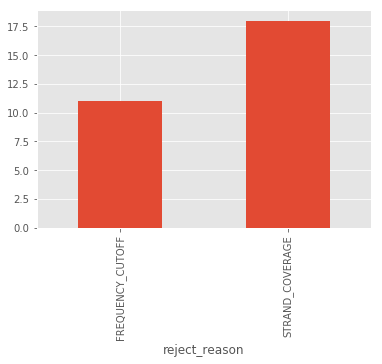

In [18]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

#How many 'None' frequencies are due to:
#1a. rejection based on evidence filters?
rejected_mutation_reasons = all_freqs_evidence.groupby('reject_reason')['mutation_x'].count()
rejected_mutation_reasons.plot.bar()

In [19]:
rejected_mutation_reasons

reject_reason
FREQUENCY_CUTOFF    11
STRAND_COVERAGE     18
Name: mutation_x, dtype: int64

In [20]:
#1b. Which ones?
all_freqs_evidence.dropna(subset=['reject_reason'])

,ref_genome_x,position,mutation_x,html_freq_anc,html_freq_100,html_freq_300,html_freq_500,html_freq_780,html_freq_1000,ref_genome_y,mutation_y,line,generation,frequency,polymorphism_frequency,new_cov,total_cov,reject_reason,evidence_type,item_id
5,NC_002937,708564,C→T,None,None,None,100%,None,None,NC_002937,C→T,UA3,100.0,1.000000,0.818228,4/5,4/7,FREQUENCY_CUTOFF,RA,111.0
17,NC_002937,1376015,C→T,None,None,None,None,None,100%,NC_002937,C→T,UA3,300.0,0.046179,0.046179,9/3,126/133,FREQUENCY_CUTOFF,RA,481.0
28,NC_002937,3140594,+GA,None,None,None,None,None,100%,NC_002937,+GA,UA3,500.0,0.800007,0.800007,20/24,29/26,STRAND_COVERAGE,RA,267.0
29,NC_002937,3140594,+GA,None,None,None,None,None,100%,NC_002937,+GA,UA3,500.0,0.800014,0.800014,20/24,29/26,STRAND_COVERAGE,RA,268.0
32,NC_002937,3140594,+GA,None,None,None,None,None,100%,NC_002937,+GA,UA3,100.0,0.600002,0.600002,2/1,2/3,STRAND_COVERAGE,RA,136.0
33,NC_002937,3140594,+GA,None,None,None,None,None,100%,NC_002937,+GA,UA3,100.0,0.600006,0.600006,2/1,2/3,STRAND_COVERAGE,RA,137.0
46,NC_005791,540893,A→G,None,None,None,100%,None,None,NC_005791,A→G,UA3,100.0,0.894805,0.894805,28/23,31/26,STRAND_COVERAGE,RA,279.0
162,NC_002937,42867,+G,100%,None,100%,100%,100%,100%,NC_002937,+G,UR1,100.0,0.926836,0.926836,17/21,18/23,STRAND_COVERAGE,RA,227.0
179,NC_002937,2083305,+C,100%,100%,100%,None,100%,100%,NC_002937,+C,UR1,500.0,1.000000,0.934467,6/8,6/9,FREQUENCY_CUTOFF,RA,174.0
190,NC_002937,2982788,+CC,None,None,None,None,None,100%,NC_002937,+CC,UR1,100.0,0.588240,0.588240,2/8,6/11,STRAND_COVERAGE,RA,344.0


In [21]:
#2. switch to consensus mode because frequencies <5%, with known evidence?
all_freqs_evidence[(all_freqs_evidence['polymorphism_frequency'] < 0.05) & (all_freqs_evidence['polymorphism_frequency'] > 0)]

,ref_genome_x,position,mutation_x,html_freq_anc,html_freq_100,html_freq_300,html_freq_500,html_freq_780,html_freq_1000,ref_genome_y,mutation_y,line,generation,frequency,polymorphism_frequency,new_cov,total_cov,reject_reason,evidence_type,item_id
17,NC_002937,1376015,C→T,None,None,None,None,None,100%,NC_002937,C→T,UA3,300.0,0.046179,0.046179,9/3,126/133,FREQUENCY_CUTOFF,RA,481.0
397,NC_002937,2497231,+TC,None,None,None,None,100%,100%,NC_002937,+TC,HA3,300.0,0.039215,0.039215,3/3,86/67,FREQUENCY_CUTOFF,RA,522.0
398,NC_002937,2497231,+TC,None,None,None,None,100%,100%,NC_002937,+TC,HA3,300.0,0.039215,0.039215,3/3,86/67,FREQUENCY_CUTOFF,RA,523.0
545,NC_002937,2081507,Δ1 bp,None,None,None,100%,None,NaN,NC_002937,Δ1 bp,HR2,100.0,0.033324,0.033324,4/1,77/73,FREQUENCY_CUTOFF,RA,327.0


In [22]:
#How many '100%' frequencies are due to:
#1. switch to consensus mode because frequencies >95%, with known evidence?
polymorphism_over_95 = all_freqs_evidence[(all_freqs_evidence['polymorphism_frequency'] < 1) & (all_freqs_evidence['polymorphism_frequency'] > 0.95)]
polymorphism_over_95.shape

(135, 20)

In [ ]:
polymorphism_over_95

In [23]:
#2. actual read frequencies of 100%?
polymorphism_100 = all_freqs_evidence[(all_freqs_evidence['polymorphism_frequency'] == 1) & ((all_freqs_evidence['reject_reason'] != 'FREQUENCY_CUTOFF') & (all_freqs_evidence['reject_reason'] != 'STRAND_COVERAGE'))]
polymorphism_100.shape

(369, 20)

In [ ]:
polymorphism_100

In [15]:
#How many frequencies are due to unknown base evidence?
all_freqs_evidence[all_freqs_evidence['evidence_type'] == 'UN'].count()
#Not all evolution lines have been sequenced at 1,000 generations.

ref_genome_x              49
position                  49
mutation_x                49
html_freq_anc             49
html_freq_100             49
html_freq_300             49
html_freq_500             49
html_freq_780             49
html_freq_1000            31
ref_genome_y              49
mutation_y                49
line                      49
generation                49
frequency                 49
polymorphism_frequency    49
new_cov                    0
total_cov                  0
reject_reason              0
evidence_type             49
item_id                   49
dtype: int64

## Part 2 Problems and Solutions

#### Use of ('ref_genome', 'position') keys to match suspect frequencies with evidence type, misses extra genome positions on JC evidence columns

JC (new junction) evidence for polymorphism (NC_002937, 629936) in line UR1 was not extracted from original annotated.gd file, because that specific (ref_genome, position) were in columns 6 (side_2_seq_id) and 7 (side_2_position). The (ref_genome, position) fields in the dataframe were extracted from columns 3 and 4, which are accurate for other evidence types, and for JC side_1_seq_id, and side_1_position.

~~- Will eventually add code to extract side_2 information for JC evidence. In the meantime, UR1 (NC_002937, 629936) is noted, but not included in analyses until code is updated.~~
- Solved, code added.

#### Duplicate ('ref_genome', 'position') keys in frequency/evidence dictionaries are deleted (Python does not allow duplicate keys).

- Solved by adding unique item_id to keys.

#### 'frequency' field from annotated.gd is frequency reported after conversion to consensus mode.

- Solved by adding polymorphism_frequency column, which reports actual frequencies in polymorphism mode.